# Chapter 4. 앙상블 (Ensemble)
결정 트리 모델은 퍼셉트론 이외에도 새로운 분류 모델을 만들 수 있다는 지표가 되었습니다. 그러나 튜닝을 어떻게 하느냐에 따라 심각한 오버피팅을 유발할 가능성이 있었고, 그에 따라 여러 개의 트리를 묶어서 랜덤 포레스트라는 모델을 만들어 이 문제를 어느 정도 해결하는 데 성공했습니다. 이렇듯 여러 개의 분류기를 하나의 메타 분류기로 연결하여 개별 분류기보다 더 좋은 일반화 성능을 달성할 수 있는 것이 확인되었고, 오늘날 우리는 이 기법들을 통틀어 **앙상블 학습**(ensemble learning)이라고 부릅니다. 이번 장에서는 다양한 앙상블 기법을 통해 예측을 하는 기법을 학습하겠습니다.

## 4.1 앙상블 학습
가장 인기 있는 앙상블 방법은 과반수 투표(majority voting) 방식입니다. 이 단순한 방식은 전체 분류기들의 과반수가 예측한 클래스 레이블을 선택하는 방법입니다. 엄밀히 말하면 과반수 투표라는 용어는 이진 클래스 분류에 해당하지만 다중 클래스 문제에도 쉽게 일반화할 수 있습니다. 이를 **다수결 투표**(plurality voting)라고 합니다. 이때는 가장 많은 투표(최빈값, mode)를 받은 클래스 레이블을 선택하면 됩니다.  
![그림 4-1](images/FIg4_1.png)  
먼저 훈련 데이터셋을 사용해 $m$개의 다른 분류기 $C_1,\cdots,C_m$을 훈련시킵니다. 앙상블 방법에 따라 결정 트리, 로지스틱 회귀 분류기와 같은 여러 알고리즘을 사용하여 구축할 수 있습니다. 또는 같은 분류 알고리즘을 사용하고 훈련 데이터셋의 부분집합(subset)을 달리하여 학습할 수도 있습니다. 유명한 앙상블 방법 중 하나가 3장 막바지에 봤던 랜덤 포레스트죠. 아래 그림은 과반수 투표를 사용한 일반적인 앙상블 방법입니다.  
![그림 4-2](images/Fig4_2.png)  
모든 가정을 만족한다면 앙상블의 오차율은 개별 분류기의 오차율보다 훨씬 낮습니다. 만약 오차율이 0.5인 분류기가 짝수 개일 때 예측이 반반으로 나뉘면 오차로 취급됩니다. 

## 4.2 다수결 투표를 사용한 분류 앙상블
이 절에서 구현할 알고리즘은 여러 가지 분류 모델의 신뢰도에 가중치를 부여하여 연결할 수 있습니다. 여기서는 특정 데이터셋에서 개별 분류기의 약점을 보완하는 강력한 메타 분류기를 구축하는 것이 목표입니다. 넘파이의 `average`와 `argmax` 함수를 사용하여 클래스 확률 기반으로 가중치가 적용된 다수결 투표를 구현할 수 있습니다. `average` 함수는 `mean` 함수와 달리 `weights`라는 배열을 매개변수로 입력함으로써 배열의 비율을 원소에 곱해 가중 평균을 구합니다. 간단한 예시를 보이면 아래와 같습니다.

In [1]:
import numpy as np

In [2]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

In [3]:
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [4]:
np.argmax(p)

0

이제 다수결 분류용 `MajorityVoteClassifier` 클래스를 구현해봅시다.

In [5]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators # 파이프라인은 이후에 7단원에서 따로 다루겠습니다.
import numpy as np
import operator

In [6]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기
    
    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)
    
    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬
        
        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터
            
        반환값
        -------
        self : 객체
        
        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬
        
        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블
        
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬
        
        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률
        
        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

In [7]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [8]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.5, 
                                                    random_state=1,
                                                    stratify=y)

조금 더 고차원적인 정확도 검증을 위해 k-겹 교차 검증(k-fold cross validation)을 사용하겠습니다. 자세한 내용은 추후에 다루도록 하고, 간단하게만 설명하자면 훈련 데이터셋을 무작위로 k개의 집단으로 나눈 뒤, k개 중 1개씩 돌아가면서 테스트 데이터셋의 역할을 맡습니다. 이를 테스트 폴드(fold)라고 합니다. 이렇게 k번의 훈련과 테스트를 거친 뒤, 추정 성능(즉, 분류 정확도 또는 오차 등)를 사용해 모델의 평균 성능을 계산하는 방식입니다. 수많은 연구와 논문을 통해 학계에서 경험적으로 얻은 지식에 따르면 일반적으로 $k=10$일 때 가장 좋은 언더피팅-오버피팅 트레이드 오프를 가집니다.  
또한 검증 지표를 나타내기 위해 정확도가 아닌 ROC AUC(Receiver Operating Characteristic Area Under the Curve)라는 지표를 사용하겠습니다. 이 지표는 모델의 예측 성능을 나타내는 ROC 곡선의 아래 면적을 계산한 것으로, 모든 예측을 정확히 했을 때 1의 값을, 하나도 맞히지 못했을 때 0의 값을 가집니다. 곡선 아래 면적이 클수록, 다시 말해 ROC AUC 점수가 높을수록 정확도가 높다고 판단할 수 있습니다.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf2]])

clf_labels = ['Logistic regression', 'Decision tree']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, pipe2], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]


여기서 로지스틱 회귀는 왜 파이프라인으로 훈련시켰는지 의문이 들 수 있습니다. 로지스틱 회귀는 결정 트리와 달리 스케일에 민감하다는 점 기억하시나요?. 붓꽃 데이터셋의 특성이 모두 같은 스케일(cm)로 측정되었지만 특성을 표준화 전처리하는 것은 좋은 습관입니다.
이제 진짜 재밌는 부분으로 넘어가죠. 다수결 투표 앙상블을 위해 `MajorityVoteClassifier` 클래스로 각 분류기를 하나로 연결하겠습니다.

In [10]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, pipe2])

clf_labels += ['Majority voting']
all_clf = [pipe1, pipe2, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.97 (+/- 0.07) [Majority voting]


결과에서 보듯이 10-겹 교차 검증으로 평가했을 때 `MajorityVoteClassifier`의 성능이 개별 분류기보다 뛰어납니다.
이어서 사이킷런의 `VotingClassifier`를 사용해 보겠습니다. `estimators` 매개변수에는 분류기 이름과 객체로 구성된 튜플의 리스트를 입력합니다. 앞에서 만든 `MajorityVoteClassifier`는 `vote` 매개변수에 상관없이 `predict_proba` 메서드를 실행할 수 있지만 사이킷런의 `VotingClassifier`는 `voting='hard'`일 경우 `predict_proba` 메서드를 지원하지 않습니다. ROC AUC를 계산하기 위해서는 예측 확률이 필요하므로 `voting='soft'`로 지정합니다.

In [11]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', pipe2)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train, 
                        cv=10, scoring='roc_auc')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(), 
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.97 (+/- 0.07) [VotingClassifier]


`VotingClassifier`의 `fit` 메서드를 호출할 때 진행 과정을 출력하려면 0.23 버전에서 추가된 `verbose` 매개변수를 `True`로 지정해야 합니다. 여기에서는 앞서 만든 `vc` 객체의 `set_params` 메서드를 사용해 `verbose` 매개변수를 설정하겠습니다.

In [12]:
vc.set_params(verbose=True)
vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 2) Processing lr, total=   0.0s
[Voting] ....................... (2 of 2) Processing dt, total=   0.0s


`voting='soft'`일 때 `predict` 메서드는 `predict_proba` 메서드에서 얻은 가장 큰 확률의 클래스를 예측으로 삼습니다. `predict_proba` 메서드는 각 분류기의 클래스 확률을 평균합니다.

In [13]:
vc.predict_proba(X_test[:10])

array([[0.7128842 , 0.2871158 ],
       [0.71197988, 0.28802012],
       [0.71113212, 0.28886788],
       [0.71764955, 0.28235045],
       [0.71793667, 0.28206333],
       [0.26551979, 0.73448021],
       [0.26505858, 0.73494142],
       [0.26768586, 0.73231414],
       [0.2694378 , 0.7305622 ],
       [0.71614302, 0.28385698]])

## 4.3 앙상블 분류기의 평가와 튜닝
이 절에서는 본 적 없는 데이터에 대한 `MajorityVoteClassifier`의 일반화 성능을 확인하기 위해 테스트 데이터셋에 대한 ROC 곡선을 그려보겠습니다. 테스트 데이터셋은 모델 선택에 사용하지 않았습니다. 테스트 데이터셋의 목적은 편향되지 않은 분류기의 일반화 성능을 추정하기 위해서입니다.

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

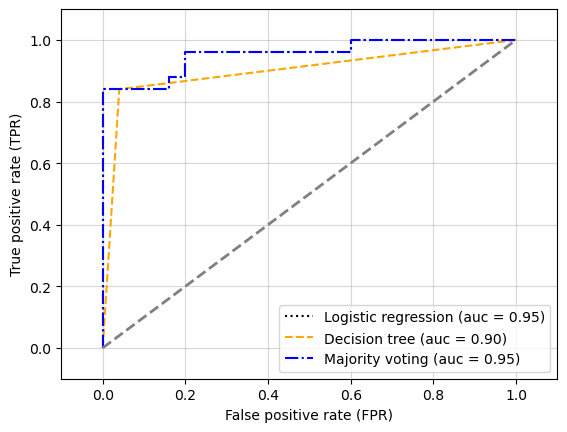

In [15]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # 양성 클래스의 레이블이 1이라고 가정합니다
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

구해진 ROC 곡선에서 보듯이 앙상블 분류기는 테스트 데이터셋에서도 좋은 성능을 냅니다(ROC AUC=0.95). 로지스틱 회귀에서도 비슷한 성능을 내는데, 이는 아마도 작은 데이터셋에서 생기는 높은 분산 때문일 것으로 추정됩니다(이 경우 데이터셋을 어떻게 분할했는지에 따라 성능이 민감하게 변화합니다).  
이 분류 문제에서는 두 개의 특성만 선택했기 때문에 앙상블의 결정 경계가 어떤 모습인지 확인해 볼 수 있습니다.  
사실 로지스틱 회귀에 파이프라인에 이미 전처리 단계가 포함되어 있기 떄문에 모델 훈련 전에 따로 특성을 표준화할 필요는 없습니다. 여기서는 결정 트리의 결정 경계를 다른 모델과 같은 스케일로 나타내기 위해 사용했습니다.

In [16]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

In [17]:
from itertools import product

In [18]:
all_clf = [pipe1, pipe2, mv_clf]

In [19]:
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

In [20]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

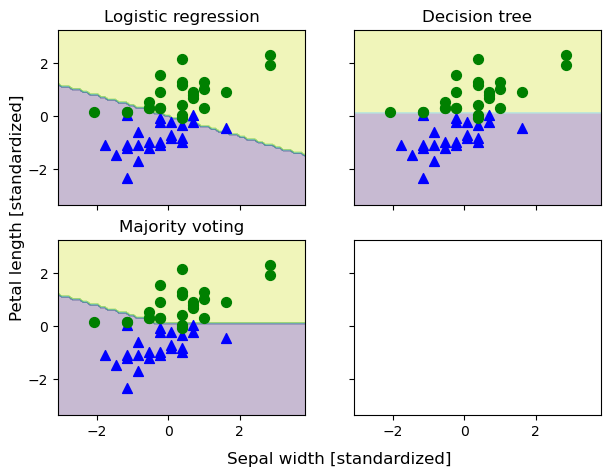

In [21]:
f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show()

이쯤에서 예상했겠지만 앙상블 분류기의 결정 경계는 개별 분류기의 결정 경계를 혼합한 것처럼 보입니다. 처음 볼 떄는 결정 경계가 $\mathsf{sepal\ width}\ge -1$을 기준으로 $y$ 축에 수직으로 그어진 결정 트리의 경계와 비슷하게 보입니다.

## 4.3 배깅: 부트스트랩 샘플링을 통한 분류 앙상블
배깅은 이전 절에서 구현한 `MajorityVoteClassifier`와 매우 밀접한 앙상블 학습 기법입니다. 앙상블에 있는 개별 분류기를 동일한 훈련 데이터셋으로 학습하는 것이 아니라 원본 훈련 데이터셋에서 부트스트랩 샘플(중복을 허용한 랜덤 샘플)을 뽑아서 사용합니다. 배깅을 bootstrap aggregating이라고도 합니다.  
![그림 4-6](https://github.com/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch07/images/07_06.png?raw=true)

### 4.3.2 배깅으로 와인 데이터셋 샘플 분류
배깅을 적용하기 위해 새로운 데이터셋인 와인 데이터셋으로 좀 더 복잡한 분류 문제를 만들어 보겠습니다. 이 데이터셋은 178개의 와인 샘플과 여러 가지 화학 성분을 나타내는 13개의 특성으로 구성되어 있습니다. 여기서는 와인 클래스 2와 클래스 3만 사용하고 두 개의 특성 `Alcohol`과 `OD280/OD315 of diluted wines`만 사용하겠습니다.

In [23]:
import pandas as pd

In [24]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

In [25]:
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [27]:
df_wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [28]:
# 클래스 1 제외하기
df_wine = df_wine[df_wine['Class label'] != 1]

In [29]:
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [30]:
from sklearn.preprocessing import LabelEncoder # 전처리 파트에서 자세히 다루겠습니다.
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1,
                                                    stratify=y)

사이킷런에는 `BaggingClassifier` 분류기가 이미 구현되어 있습니다. 이 클래스는 `ensemble` 모듈에서 임포트할 수 있습니다. 여기서는 훈련 데이터셋으로부터 추출한 부트스트랩 샘플에서 가지치기가 없는 500개의 결정 트리를 학습하여 앙상블을 만들겠습니다.

In [31]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [32]:
tree = DecisionTreeClassifier(criterion='entropy', # 지니 불순도 대신 엔트로피를 기준으로 구분
                              max_depth=None,
                              random_state=1)

In [33]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

다음으로 배깅 분류기와 가지치기가 없는 단일 결정 트리에서 훈련 데이터셋과 테스트 데이터셋의 예측 정확도를 계산하여 성능을 비교합니다.

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [36]:

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833


In [37]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

In [38]:
bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (bag_train, bag_test))

배깅의 훈련 정확도/테스트 정확도 1.000/0.917


출력된 정확도를 보면 가지치기가 없는 결정 트리는 모든 훈련 샘플을 정확하게 예측했습니다. 그러나 정작 중요한 테스트 데이터셋의 정확도는 확실히 낮기 때문에 모델이 오버피팅되어 있음을 나타냅니다.  
결정 트리와 배깅 분류기의 훈련 정확도가 훈련 데이터셋과 비슷하지만 (둘 다 100%), 테스트 데이터셋의 정확도로 미루어볼 때 배깅 분류기가 일반화 성능이 더 나을 것 같습니다. 다음으로 이 두 분류기의 결정 경계를 비교해봅시다.

In [39]:
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

In [40]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

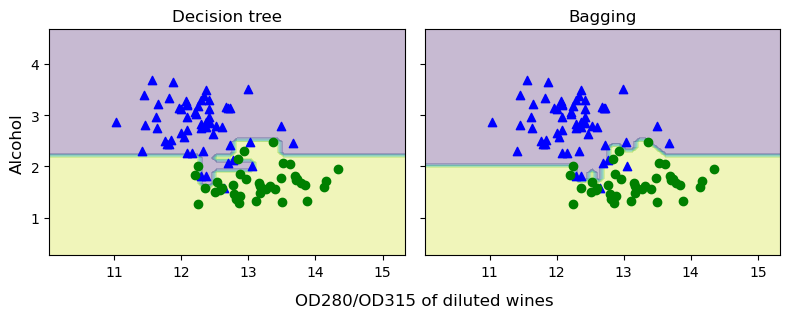

In [42]:
f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))
for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)
plt.show()

결과 그래프에서 보듯이 결정 트리의 선형 결정 경계가 배깅 앙상블에서 더 부드러워졌습니다.  
실전에서 고차원 데이터셋을 사용하는 더 복잡한 분류 문제라면 단일 결정 트리가 쉽게 오버피팅될 수 있습니다. 이런 경우에 배깅 알고리즘의 강력함이 제대로 발휘될 수 있습니다.  
마지막으로 배깅 알고리즘은 오버피팅을 감소시키는 데는 효과적이지만, 반대로 언더피팅의 감소에는 효과적이지 않습니다. 즉, 모델이 너무 단순해서 데이터에 있는 경향을 잘 잡아내지 못합니다. 이것이 배깅을 수행할 때 가지치기하지 않은 결정 트리와 같이 복잡한 결정 트리를 분류기로 사용해 앙상블을 만드는 이유입니다.

### 4.3.3 OOB 샘플
랜덤 포레스트와 배깅은 모두 기본적으로 부트스트랩 샘플링을 사용하기 때문에 분류기마다 훈련에 사용하지 않는 여분의 샘플이 남습니다. 이를 OOB(Out-Of-Bag) 샘플이라고 합니다. 이 샘플을 이용하면 검증 데이터셋을 만들지 않고도 앙상블 모델을 평가할 수 있습니다. 사이킷런에서는 `oob_score` 매개변수를 `True`로 설정하면 됩니다. 이 매개변수의 기본값은 `False`입니다.  
사이킷런의 랜덤 포레스트는 분류일 경우 OOB 샘플에 대한 각 트리의 예측 확률을 누적하여 가장 큰 확률을 가진 클래스를 타겟과 비교하여 정확도를 계산합니다. 회귀일 경우에는 각 트리의 예측 평균에 대한 $R^2$ 점수를 계산합니다. 이 점수는 `oob_score_` 속성에 저장되어 있습니다. `RandomForestClassifier`에 와인 데이터셋을 적용하여 OOB 점수를 계산해보겠습니다.

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
rf = RandomForestClassifier(oob_score=True,
                            random_state=1)

In [45]:
rf.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=1)

In [46]:
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

In [47]:
print('랜덤 포레스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (rf_train_score, rf_test_score))
print('랜덤 포레스트의 OOB 정확도 %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.917
랜덤 포레스트의 OOB 정확도 0.884


배깅의 OOB 점수 계산 방식은 랜덤 포레스트와 거의 동일합니다. 다만 `base_estimator`에 지정된 분류기가 `predict_proba` 메서드를 지원하지 않을 경우 예측 클래스를 카운팅하여 가장 높은 값의 클래스를 사용해 정확도를 계산합니다. 본문에서 만든 것과 동일한 `BaggingClassifier` 모델를 만들고 OOB 점수를 계산해 보겠습니다.

In [48]:
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        random_state=1)

In [49]:
bag.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                        random_state=1),
                  n_estimators=500, oob_score=True, random_state=1)

In [50]:
bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)

In [51]:
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' % 
      (bag_train_score, bag_test_score))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


## 4.4 약한 학습기를 이용한 에이다부스트
마지막 앙상블 기법은 **부스팅**(boosting)입니다. 여기서는 그 중 가장 유명한 부스팅 기법인 에이다부스트(AdaBoost, Adaptive Boosting)에 초점을 맞추겠습니다.  
부스팅에서 앙상블은 **약한 학습기**(weak learner)라고도 하는 매우 간단한 분류기로 구성됩니다. 이 분류기의 성능이라고 해봐야 랜덤 추측~~한마디로 찍어서 얻어걸리기~~보다 조금 성능이 좋을 뿐입니다. 약한 학습기의 전형적인 예는 깊이가 1인 결정 트리가 있습니다.~~이걸로 뭘 분류를 해...~~ 부스팅의 핵심 아이디어는 분류하기 어려운 훈련 샘플에 초점을 맞추는 것입니다. 즉, 잘못 분류된 훈련 샘플을 그 다음 약한 학습기가 학습하여 앙상블 성능을 향상시킵니다. 
### 4.4.1 부스팅 작동 원리
배깅과 달리 부스팅의 초창기 방법은 중복을 허용하지 않고 훈련 데이터셋에서 랜덤 샘플을 추출하여 부분집합을 구성합니다. 원본 부스팅 과정은 다음 네 개의 주요 단계로 요약할 수 있습니다.  
1. 훈련 데이터셋 $D$에서 중복을 허용하지 않고 랜덤한 부분집합 $d_1$을 뽑아 약한 학습기 $C_1$을 훈련합니다.
2. 훈련 데이터셋에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분집합 $d_2$를 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기 $C_2$를 훈련합니다.
3. 훈련 데이터셋 $D$에서 $C_1$과 $C_2$에서 잘못 분류한 훈련 샘플 $d_3$를 찾아 세 번째 약한 학습기인 $C_3$를 훈련합니다. 
4. 약한 학습기 $C_1$, $C_2$, $C_3$를 다수결 투표로 연결합니다.  

![그림 4-9](https://github.com/rickiepark/python-machine-learning-book-3rd-edition/blob/master/ch07/images/07_09.png?raw=true)

### 4.4.2 사이킷런에서 에이다부스트 사용
이전 절에서 배깅 분류기를 훈련할 때 사용한 와인 데이터셋을 다시 사용합니다. `base_estimator` 속성으로 깊이가 1인 결정 트리를 전달하여 트리 500개로 구성된 `AdaBoostClassifier`를 훈련시킵니다.

In [52]:
from sklearn.ensemble import AdaBoostClassifier

In [53]:
# 약한 분류기 - 깊이 1짜리 결정 트리
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

In [54]:
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [55]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [56]:
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875


In [57]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

In [58]:
ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

에이다부스트의 훈련 정확도/테스트 정확도 1.000/0.917


보다시피 깊이가 1인 결정 트리는 과소적합된 것 같습니다. 이전 절에서 보았던 가지치기가 없는 결정 트리와는 반대입니다.  
에이다부스트 모델은 훈련 데이터셋의 모든 클래스 레이블을 정확하게 예측하고 깊이가 1인 결정 트리에 비해 테스트 데이터셋 성능도 높습니다. 훈련 성능과 테스트 성능 사이의 간격이 크므로 모델의 편향을 줄임으로써 추가적인 분산이 발생했습니다.  
끝으로 결정 영역의 모습을 확인하겠습니다.

In [60]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1

In [61]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

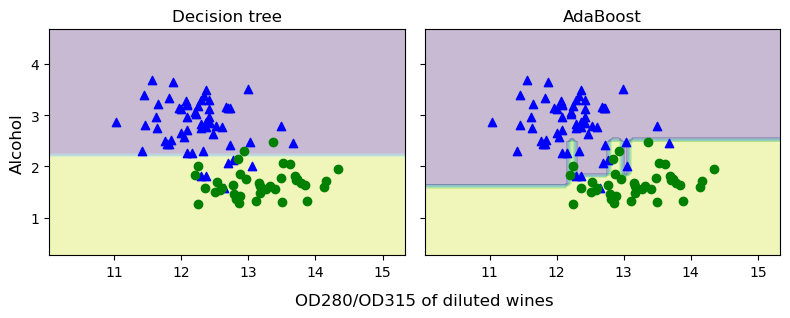

In [62]:
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))
for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)
plt.show()

결정 영역을 그려보면 에이다부스트 모델의 결정 경계가 깊이 1인 결정 트리의 결정 경계보다 확실히 더 복잡합니다. 또 에이다부스트 모델이 이전 절에서 훈련한 배깅 분류기와 매우 비슷하게 특성 공간을 분할하고 있습니다.  

----------------------------------------------------
앙상블 기법을 마무리하면서 언급할 점은, 앙상블 학습은 개별 분류기에 비해 계산 복잡도가 높다는 점입니다. 실전에서는 비교적 많지 않은 예측 성능 향상을 위해 계산 비용에 더 투자할 것인지 주의 깊게 생각해야 합니다.  
이 트레이드 오프(trade-off)의 예로 주로 인용되는 것은 앙상블 기법을 사용해 우승자가 가려진 100만 달러 넷플릭스 대회(Netflix Prize)입니다. 자세한 알고리즘 내용은 [온라인](http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html)에 공개되어 있습니다. 우승 팀은 100만 달러 상금을 받았지만 복잡도가 높아 실제 애플리케이션에 적용하기 어렵기 때문에 넷플릭스는 이 모델을 구현하지 않았습니다.  
> "새로운 방법들을 오프라인에서 평가했지만 추가로 얻을 수 있는 정확도 향상이 운영 시스템에 적용하기 위해 필요한 노력만큼 가치 있어 보이지 않았습니다."